In [1]:
%pylab inline

import matplotlib.pyplot as plt
import requests
import zipfile
import re
from collections import Counter

import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, GloVe, vocab


from functools import partial,reduce
from tqdm import tqdm, trange
tqdm = partial(tqdm, position=0, leave=True)
trange = partial(trange, position=0, leave=True)

import numpy as np


DEVICE = 'cuda:0'

Populating the interactive namespace from numpy and matplotlib


In [ ]:
url = 'http://www.cs.cornell.edu/~cristian/data/cornell_movie_dialogs_corpus.zip'

r = requests.get(url)

ul = url.split('/')
name = ul[len(ul) - 1]

with open(name, 'wb') as file:
  file.write(r.content)

with zipfile.ZipFile(name, "r") as zip_ref:
  zip_ref.extractall("./")

!mv 'cornell movie-dialogs corpus' 'data'
!ls 'data'

mv: cannot move 'cornell movie-dialogs corpus' to 'data/cornell movie-dialogs corpus': Directory not empty
 chameleons.pdf			 movie_lines.txt
'cornell movie-dialogs corpus'	 movie_titles_metadata.txt
 movie_characters_metadata.txt	 raw_script_urls.txt
 movie_conversations.txt	 README.txt


In [ ]:
FIELD_SPLITTER = '+++$+++'

MAX_SAMPLES = 50000
MAX_LENGTH = 40

UNK_TOKEN = '<unk>'
PAD_TOKEN = '<PAD>'
BOS_TOKEN = '<BOS>'
EOS_TOKEN = '<EOS>'

UNK_TOKEN_IND = 0
PAD_TOKEN_IND = 1
BOS_TOKEN_IND = 2
EOS_TOKEN_IND = 3

BATCH = 128

In [ ]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^a-zA-Z?.!,]+", " ", sentence)
    sentence = sentence.strip()
    return sentence

In [ ]:
text_transform = lambda x, voc, tokenizer: [voc['<BOS>']] + [voc[token] for token in tokenizer(x)] + [voc['<EOS>']]

In [ ]:
# this is terrible as fuck because torchtext is terrible as fuck
def load_conversations(path_to_movie_lines, path_to_movie_conversations):
    id2line = {}
    with open(path_to_movie_lines, errors='ignore') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.replace('\n', '').split(' +++$+++ ')
            id2line[parts[0]] = parts[4]

    inputs, outputs = [], []
    with open(path_to_movie_conversations, 'r') as file:
        lines = file.readlines()
        for line in lines:
            parts = line.replace('\n', '').split(' +++$+++ ')
            conversation = [line[1:-1] for line in parts[3][1:-1].split(', ')]
            for i in range(len(conversation) - 1):
                inputs.append(preprocess_sentence(id2line[conversation[i]]))
                outputs.append(preprocess_sentence(id2line[conversation[i + 1]]))
                if len(inputs) >= MAX_SAMPLES:
                    return inputs, outputs
    return inputs, outputs


In [ ]:
def get_dataloader(path_to_movie_lines,
                   path_to_movie_conversations):
    questions, answers = load_conversations(path_to_movie_lines, path_to_movie_conversations)

    tokenizer = get_tokenizer('basic_english')

    counter = Counter()
    for sent in questions + answers:
        counter.update(tokenizer(sent))

    voc = vocab(counter)
    voc.insert_token(token=UNK_TOKEN, index=UNK_TOKEN_IND)
    voc.set_default_index(index=UNK_TOKEN_IND)
    voc.insert_token(token=PAD_TOKEN, index=PAD_TOKEN_IND)
    voc.insert_token(token=BOS_TOKEN, index=BOS_TOKEN_IND)
    voc.insert_token(token=EOS_TOKEN, index=EOS_TOKEN_IND)

    q_tokenized = [text_transform(t, voc, tokenizer) for t in questions]
    a_tokenized = [text_transform(t, voc, tokenizer) for t in answers]

    import tensorflow as tf # todo
    q_padded = tf.keras.preprocessing.sequence.pad_sequences(
        q_tokenized, maxlen=MAX_LENGTH, padding='post', value=1.0)

    a_padded = tf.keras.preprocessing.sequence.pad_sequences(
        a_tokenized, maxlen=MAX_LENGTH, padding='post', value=1.0)

    print("Vocab len", len(voc))

    dataloader = DataLoader(
        list(
            zip(
                  q_padded.astype(np.float32),
                  a_padded.astype(np.float32),
                )
            ),
            batch_size=BATCH,
            shuffle=False,
    )

    print(voc)
    torch.save(voc, 'vocab')

    return dataloader, text_transform, voc


In [ ]:
lines_path = 'data/movie_lines.txt'
conversations_path = 'data/movie_conversations.txt'    

dataloader, text_transform, voc = get_dataloader(lines_path,
                                                 conversations_path)

Vocab len 23068
Vocab()


In [ ]:
test_sample = None

for i,x in enumerate(dataloader):
  if i > 1: break
  print(x[0].shape)
  test_sample = x[0]

torch.Size([128, 40])
torch.Size([128, 40])


In [2]:
# https://arxiv.org/pdf/1706.03762.pdf
def sdpa_attention(q, k, v):
    d = torch.sqrt(torch.tensor(k.shape[len(k.shape) - 1]))
    scales = torch.matmul(q, k) / d
    # mask?
    weights = f.softmax(scales, dim=-1)
    res = torch.matmul(weights, v)
    return res
    

In [ ]:
class MultiheadAttention(nn.Module):
  def __init__(self):
    super(MultiheadAttention, self).__init__()

    self.V = nn.Linear(1, 1)
    self.K = nn.Linear(1, 1)
    self.Q = nn.Linear(1, 1)
    self.O = nn.Linear(1, 1)

  def forward(self, q, k, v):
    q = self.Q(q)
    k = self.Q(k)
    v = self.Q(v)

    a = sdpa_attention(q, k, v)
    o = self.O(a)

    return o


In [ ]:
print(test_sample.shape)
print(test_sample.dtype)

torch.Size([128, 40])
torch.float32


In [ ]:
# todo

EPOCHS = 20

losses = []

In [ ]:
for epoch in trange(EPOCHS):
  for i, data in tqdm(enumerate(dataloader)):
    i_seq = data[0].to(DEVICE)



391it [00:02, 165.17it/s]
391it [00:02, 167.36it/s]
391it [00:02, 169.72it/s]
391it [00:02, 166.97it/s]
391it [00:02, 170.58it/s]
391it [00:02, 149.98it/s]
391it [00:02, 172.39it/s]
391it [00:02, 169.37it/s]
391it [00:02, 173.18it/s]
391it [00:02, 150.08it/s]
391it [00:02, 152.61it/s]
391it [00:02, 171.22it/s]
391it [00:02, 167.04it/s]
391it [00:02, 171.93it/s]
391it [00:02, 170.63it/s]
391it [00:02, 169.05it/s]
391it [00:02, 168.36it/s]
391it [00:02, 172.01it/s]
391it [00:02, 170.24it/s]
391it [00:02, 171.01it/s]
100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


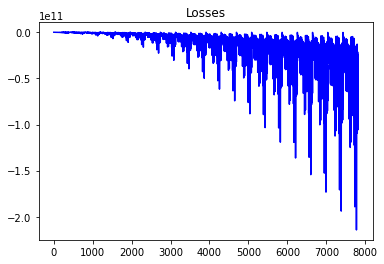

In [ ]:
plt.plot(range(len(losses)), losses, 'b', label='Loss')
plt.title('Losses')
plt.show()

In [ ]:
query = 'test'

q_tr = text_transform(query, voc, get_tokenizer('basic_english'))
import tensorflow as tf
q_p = tf.keras.preprocessing.sequence.pad_sequences(
    [q_tr],
    maxlen=MAX_LENGTH,
    padding='post',
    value=1.0
)
q_t = torch.Tensor(q_p).float().to(DEVICE)


enc = encoder(q_t)
dec, _ = decoder(enc)

print(dec.int())

tokens = [t.int().item() for t in dec[0]]
words = voc.get_itos()
result = ' '.join(list(filter(lambda w: '<' not in w and '>' not in w, [words[t] for t in tokens])))
print('\n\n')
print(result)



tensor([[ -869, -1392, -1191,     0, -1605,     0,     0, -1214, -1530, -1462,
         -1104, -1115,     0, -1451, -1414,     0, -1253,  1159,     0, -1447,
         -1145,   162, -1305,     0,  -805,     0, -1033,     0,     0, -1142,
             0,     0, -1221,     0,     0, -1269,     0, -1423, -1202, -1298,
         -1378, -1492,  -639,     0,     0,     0,  -508,  1187, -1514,     0,
         -1470, -1266,     0,     0,     0, -1381,  1165,  -108,    29, -1472,
             0, -1564,     0, -1408,     0,     0, -1357,  -820,  -659,     0,
         -1261, -1532,  1041, -1188, -1505,     0,  1098, -1349, -1287, -1373,
         -1207,  -505,     0, -1456, -1412,  1637,  -673, -1470,     0, -1579,
         -1386, -1404,     0, -1531,     0, -1405,     0, -1066, -1484, -1412,
         -1564,     0, -1484,   425, -1288,   719, -1137,  -841, -1418, -1240,
         -1256,  -893,     0,     0, -1539,     0,    10,     0, -1081, -1063,
         -1156, -1229, -1434,     0,     0,  -868, -

In [ ]:
!tail -n 10 data/movie_conversations.txt 

u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666460', 'L666461']
u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666485', 'L666486']
u9027 +++$+++ u9029 +++$+++ m616 +++$+++ ['L666546', 'L666547']
u9028 +++$+++ u9033 +++$+++ m616 +++$+++ ['L666497', 'L666498', 'L666499', 'L666500', 'L666501', 'L666502']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666262', 'L666263', 'L666264']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666324', 'L666325', 'L666326', 'L666327']
u9028 +++$+++ u9031 +++$+++ m616 +++$+++ ['L666575', 'L666576']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666256', 'L666257']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666369', 'L666370', 'L666371', 'L666372']
u9030 +++$+++ u9034 +++$+++ m616 +++$+++ ['L666520', 'L666521', 'L666522']


In [ ]:
!ls data

 chameleons.pdf			 movie_lines.txt
'cornell movie-dialogs corpus'	 movie_titles_metadata.txt
 movie_characters_metadata.txt	 raw_script_urls.txt
 movie_conversations.txt	 README.txt


In [ ]:
!cat data/README.txt

Cornell Movie-Dialogs Corpus

Distributed together with:

"Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs"
Cristian Danescu-Niculescu-Mizil and Lillian Lee
Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011.

(this paper is included in this zip file)

NOTE: If you have results to report on these corpora, please send email to cristian@cs.cornell.edu or llee@cs.cornell.edu so we can add you to our list of people using this data.  Thanks!


Contents of this README:

	A) Brief description
	B) Files description
	C) Details on the collection procedure
	D) Contact


A) Brief description:

This corpus contains a metadata-rich collection of fictional conversations extracted from raw movie scripts:

- 220,579 conversational exchanges between 10,292 pairs of movie characters
- involves 9,035 characters from 617 movies
- in total 304,713 utterances
- movie metadata included:
	- genres
	- relea

In [ ]:
# # trash




# def preprocess(x):
#   x_no_new = x.replace('\n', '')
#   text = x_no_new.split(FIELD_SPLITTER).pop()
#   embedding = g_vectors.get_vecs_by_tokens(tokenizer(text), lower_case_backup=True)
#   return embedding

# tokenizer = get_tokenizer('basic_english')
# g_vectors = GloVe(name='840B')
# g_vocab = vocab(g_vectors.stoi)


# train_iter = tt.data.BucketIterator(
#   dataset=train_obj,
#   batch_size = 2,
#   sort_key=lambda x: len(x.review),
#   shuffle=True,
#   device=DEVICE
# )

# trainloader = torch.utils.data.DataLoader(
# 	,
# 	batch_size=BATCH,
# 	num_workers=12,
# 	shuffle=True
# )

In [ ]:

# embeddings = global_vectors.get_vecs_by_tokens(tokenizer("Hello, How are you?"),
#                                                lower_case_backup=True)
# embeddings
# 
# 
# 
# def batch(iterable, size):
#     from itertools import chain, islice
#     iterator = iter(iterable)
#     for first in iterator:
#         yield list(chain([first], islice(iterator, size - 1)))